<a href="https://colab.research.google.com/github/inspire-lab/CyberAI-labs/blob/main/category-PrivateAI/Privacy-preserving-reinforcement-learning/Privacy_preserving_q_learning(dp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Privacy-preserving Q-Learning [Using Differential Privacy]

In [ ]:
!git clone https://github.com/prajwalpanzade/differentially-private-q-learning

Cloning into 'differentially-private-q-learning'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14 (from 1)
Receiving objects: 100% (14/14), 13.70 KiB | 13.70 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
%matplotlib inline

In [ ]:
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
import numpy as np

class hitorstandcontinuous:
    def __init__(self):
        self.observation_space = Box(0*np.ones(1), 1.0*np.ones(1), dtype=np.float64)
        self.action_space = Discrete(2)
        self.num_envs = 1
        self.cnt = 0
        self.length = 50

    def step(self, action):
        self.cnt += 1
        #if action == 1:
        #    if self.state > 0.5:
        #        self.state = np.random.uniform(0.0, self.state, (1,))
        #    else:
        #        self.state = np.random.uniform(self.state, 1.0, (1,))
        #reward = 0.0
        if action == 0:
            self.state = min(self.state + np.random.uniform(0.0, 0.25, (1,)), np.array([1.0]))
        elif action == 1:
            self.state = max(self.state - np.random.uniform(0.0, 0.25, (1,)), np.array([0.0]))
        done = np.array([self.cnt == self.length])
        reward = float(0.5 - np.abs(self.state-0.5))
        if done:
            self.cnt = 0
        #    reward = float(self.state)
        return self.state, reward, done, None

    def reset(self):
        self.cnt = 0
        self.state = np.random.uniform(0.0, 1.0, (1,))
        return self.state

    def render(self):
        raise NotImplementedError

    def seed(self, seed_value):
        np.random.seed(seed)
        print('numpy seed is changed to {} globally'.format(seed))


Differentially Private Q-Learning in continuous spaces
=====================================
**Original Author**: Removed for anonymity; Will reveal and thank the author in the public version of the paper


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v0 task from the `OpenAI Gym <https://gym.openai.com/>`__.

**Packages**


First, let's import needed packages. Firstly, we need
`gym <https://gym.openai.com/docs>`__ for the environment
(Install using `pip install gym`).
We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)
-  utilities for vision tasks (``torchvision`` - `a separate
   package <https://github.com/pytorch/vision>`__).




In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


env = hitorstandcontinuous()
m = env.action_space.n

seed = 3
np.random.seed(seed)
torch.manual_seed(seed)


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = "cpu"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Task for test**
=====================================

The agent has to decide between two actions - moving the cart left or
right - If the agent choose to move left (right), its position will be moved randomly to the left (right) randomly by 0 to 0.25.
The state space is between 0 and 1.
The reward is given by 0.5 minus its distance to the middle point.

**Noise Buffer**
=====================================

We use noise buffer to represent the Gaussian process noise. The buffer remembers the previous evaluations of the sample path and efficiently infers the new queries.

In [ ]:
import bisect
import numpy as np

def kk(x, y):
    return np.exp(-abs(x-y))

def rho(x, y):
    return np.exp(abs(x-y)) - np.exp(-abs(x-y))

class noisebuffer:
    def __init__(self, m, sigma):
        self.buffer = []
        self.base = {}
        self.m = m
        self.sigma = sigma

    def sample(self, s):
        buffer = self.buffer
        sigma = self.sigma

        if len(buffer) == 0:
            v0 = np.random.normal(0, sigma)
            v1 = np.random.normal(0, sigma)
            self.buffer.append((s, v0, v1))
            return (v0, v1)
        else:
            idx = bisect.bisect(buffer, (s, 0, 0))
            if len(buffer) == 1:
                if buffer[0][0] == s:
                    return (buffer[0][1], buffer[0][2])
            else:
                if (idx <= len(buffer)-1) and (buffer[idx][0] == s):
                    return (buffer[idx][1], buffer[idx][2])
                elif (idx >= 1) and (buffer[idx-1][0] == s):
                    return (buffer[idx-1][1], buffer[idx-1][2])
                elif (idx <= len(buffer)-2) and (buffer[idx+1][0] == s):
                    return (buffer[idx+1][1], buffer[idx+1][2])

        if s < buffer[0][0]:
            mean0 = kk(s, buffer[0][0]) * buffer[0][1]
            mean1 = kk(s, buffer[0][0]) * buffer[0][2]
            var0 = 1 - kk(s, buffer[0][0]) ** 2
            var1 = 1 - kk(s, buffer[0][0]) ** 2
            v0 = np.random.normal(mean0, np.sqrt(var0) * sigma)
            v1 = np.random.normal(mean1, np.sqrt(var1) * sigma)
            self.buffer.insert(0, (s, v0, v1))
        elif s > buffer[-1][0]:
            mean0 = kk(s, buffer[-1][0]) * buffer[0][1]
            mean1 = kk(s, buffer[-1][0]) * buffer[0][2]
            var0 = 1 - kk(s, buffer[-1][0]) ** 2
            var1 = var0
            v0 = np.random.normal(mean0, np.sqrt(var0) * sigma)
            v1 = np.random.normal(mean1, np.sqrt(var1) * sigma)
            self.buffer.insert(len(buffer), (s, v0, v1))
        else:
            idx = bisect.bisect(buffer, (s, None, None))
            sminus, eminus0, eminus1 = buffer[idx-1]
            splus, eplus0, eplus1 = buffer[idx]
            mean0 = (rho(splus, s)*eminus0 + rho(sminus, s)*eplus0) / rho(sminus, splus)
            mean1 = (rho(splus, s)*eminus1 + rho(sminus, s)*eplus1) / rho(sminus, splus)
            var0 = 1 - (kk(sminus, s)*rho(splus, s) + kk(splus, s)*rho(sminus, s)) / rho(sminus, splus)
            var1 = var0
            v0 = np.random.normal(mean0, np.sqrt(var0) * sigma)
            v1 = np.random.normal(mean1, np.sqrt(var1) * sigma)
            self.buffer.insert(idx, (s, v0, v1))
        return (v0, v1)

    def reset(self):
        self.buffer = []

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
'''
nb = noisebuffer(2, 1.)
print(nb.sample(0.5))
print(nb.sample(0.3))
print(nb.sample(0.7))
print(nb.sample(0.4))
print(nb.sample(0.5))
print(nb.sample(0.7))
'''

'\nnb = noisebuffer(2, 1.)\nprint(nb.sample(0.5))\nprint(nb.sample(0.3))\nprint(nb.sample(0.7))\nprint(nb.sample(0.4))\nprint(nb.sample(0.5))\nprint(nb.sample(0.7))\n'

Replay Memory
-------------

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It maps essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the original state returned by the environment.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let quickly recap what a DQN is.

DQN algorithm
-------------

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. It makes rewards from the uncertain far
future less important for our agent than the ones in the near future
that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

Q-network
=====================================

Our model will be a MLP network that takes in the
original state returned by the environment. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [ ]:
class DQN(nn.Module):

    def __init__(self, hidden=16):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(1, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.head = nn.Linear(hidden, m)
        self.nb = noisebuffer(2, 0.4)


    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, s):
        x = F.relu(self.linear1(s))
        x = F.relu(self.linear2(x))
        x = self.head(x)
        eps = [self.nb.sample(float(state)) for state in s]
        eps = torch.Tensor(eps)
        return x + eps

Training
--------

Hyperparameters and utilities
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest value for column of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(m)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

Training loop
=========================

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By defition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network has its weights kept frozen most of
the time, but is updated with the policy network's weights every so often.
This is usually a set number of steps but we shall use episodes for
simplicity.




In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask =

    #####################
    #Your code goes here
    #####################
    non_final_next_states =

    #####################
    #Your code goes here
    #####################
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    #import pdb; pdb.set_trace()
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values =
    #####################
    #Your code goes here
    #####################

    # Compute Huber loss
    loss =
    #####################
        #Your code goes here
        #####################

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below, you can find the main training loop. At the beginning we reset
the environment and initialize the ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set small. You should download
the notebook and run lot more epsiodes, such as 300+ for meaningful
duration improvements.




In [ ]:
num_episodes = 100
episodic_rewards = []
for i_episode in range(num_episodes):
    if i_episode % 10 == 0:
        print(i_episode)
    # Initialize the environment and state
    state = torch.Tensor(env.reset()).unsqueeze(0)
    total_reward = 0
    for t in count():
        # Select and perform an action
        action = select_action(state)
        next_state, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.Tensor(next_state).unsqueeze(0)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        #import pdb; pdb.set_trace()
        total_reward += float(reward.squeeze(0).data)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    episodic_rewards.append(total_reward)
    #policy_net.nb.reset()
    #target_net.nb.reset()

print('Complete')
plt.ioff()
plt.show()

<ipython-input-3-83cbe731b097>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = float(0.5 - np.abs(self.state-0.5))
<ipython-input-10-436da2c72313>:32: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


0
10
20
30
40
50
60
70
80
90
Complete


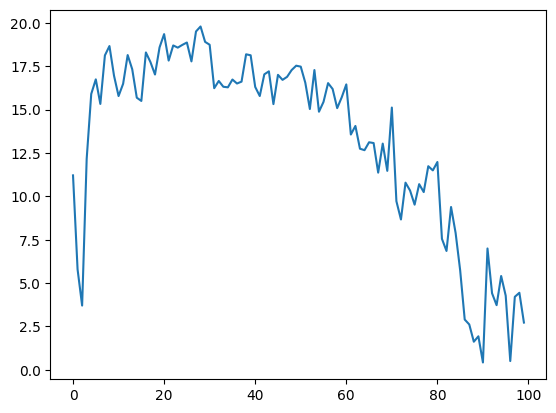

In [ ]:
plt.plot(episodic_rewards)
plt.show()

In [ ]:
state = torch.Tensor(env.reset()).unsqueeze(0)
policy_net(state)

tensor([[8.7290, 8.1188]], grad_fn=<AddBackward0>)

In [ ]:
print(episodic_rewards)
with open('dpql.txt', 'a') as fw:
    for rr in episodic_rewards:
        fw.write(str(rr))
        fw.write(' ')
    fw.write('\n')

[11.210192017257214, 5.789667807519436, 3.7019783202558756, 12.16593757783994, 15.90492209047079, 16.74672183394432, 15.330607613548636, 18.129511691629887, 18.667399153113365, 16.961162630468607, 15.785146726295352, 16.490255065262318, 18.148310020565987, 17.330419197678566, 15.68991726404056, 15.502887099981308, 18.29928931593895, 17.74358554929495, 17.0265039652586, 18.591218173503876, 19.35616859793663, 17.830298602581024, 18.703265115618706, 18.576822102069855, 18.734123654663563, 18.872401118278503, 17.782804012298584, 19.50846567749977, 19.796819642186165, 18.90910665690899, 18.743654787540436, 16.237282196059823, 16.654140956699848, 16.320892959833145, 16.287513256072998, 16.73784901574254, 16.50734280794859, 16.615423530340195, 18.192084416747093, 18.135568141937256, 16.310486905276775, 15.786290489137173, 17.036785811185837, 17.209748148918152, 15.320347882807255, 17.00733122229576, 16.717873081564903, 16.891591161489487, 17.28366094827652, 17.535548150539398, 17.480584129691

### References


1. [https://github.com/wangbx66/differentially-private-q-learning](https://github.com/wangbx66/differentially-private-q-learning)
2. https://proceedings.neurips.cc/paper_files/paper/2019/file/6646b06b90bd13dabc11ddba01270d23-Paper.pdf

